# Emergency braking into MNE 

<br>

<hr>

## Description

This notebook converts the data that have been presented into format readable by the library MNE 

Haufe S, Treder M S, Gugler M F, Sagebaum M, Curio G and
Blankertz B 2011 EEG potentials predict upcoming emergency
brakings during simulated driving J. Neural Eng. 8 056001


In [1]:
# Imports
import scipy.io
import h5py
import time
from h5py import File 
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne.channels import make_standard_montage

from sklearn.pipeline import make_pipeline
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
# Path to raw data
path_data_mat = '/Users/obando_c/Documents/Neuro/EmergencyBraking/Data/Raw/'

# File name of one subject
file_name = "VPja.mat" 

# Path to save process data
path_postprocess_mat = '/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/'

### Extract data

**cnt**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;  *Structure containing the data of different channels: EEG, EMGf, 'lead_gas', 'lead_brake', 'dist_to_lead', 'wheel_X', 'wheel_Y', 'gas', 'brake'*  <br>
**mnt**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;*Structure defining electrode positions*  <br>
**mrk** &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;  *Structure containing the braking event* <br>
<!--- **cnt.clab**  &emsp; &emsp; &emsp; &emsp;&emsp;*EEG electrodes names* <br> -->   
<!--- **mrk/className**   &emsp; *Names of the different types of events*--> 

In [3]:
start = time.time()
with h5py.File(path_data_mat + file_name, 'r') as f:
    print("Number of items in ",file_name, ": ", len(list(f)))
    print("Items inside ",file_name, ": ", list(f.items()))
    cnt = f.get('cnt')
    print("Items in cnt", list(cnt.items()) )
    T = np.array(cnt.get('T'))
    clab = np.array(cnt.get('clab')) # clab is the electrode names
    file = np.array(cnt.get('file'))
    fs = np.array(cnt.get('fs')) # fs is the sampling rate: 200
    title = np.array(cnt.get('title'))
    x = np.array(cnt.get('x')) # x is the continuous multivariate data
    
end = time.time()
print("Elapsed time:", (end - start), "s")

Number of items in  VPja.mat :  4
Items inside  VPja.mat :  [('#refs#', <HDF5 group "/#refs#" (144 members)>), ('cnt', <HDF5 group "/cnt" (6 members)>), ('mnt', <HDF5 group "/mnt" (8 members)>), ('mrk', <HDF5 group "/mrk" (4 members)>)]
Items in cnt [('T', <HDF5 dataset "T": shape (3, 1), type "<f8">), ('clab', <HDF5 dataset "clab": shape (69, 1), type "|O">), ('file', <HDF5 dataset "file": shape (8, 1), type "<u2">), ('fs', <HDF5 dataset "fs": shape (1, 1), type "<f8">), ('title', <HDF5 dataset "title": shape (22, 1), type "<u2">), ('x', <HDF5 dataset "x": shape (69, 1619951), type "<f8">)]
Elapsed time: 6.9898152351379395 s


In [4]:
# Extract name of channels 
f = h5py.File(path_data_mat + file_name,'r') 
test = f['cnt/clab']
name_elec = list()
for j in range(len(test)):
    st = test[j][0]
    obj = f[st]
    str1 = ''.join(chr(i) for i in obj[:])
    name_elec.append(str1)
print("Names of channels:", name_elec)

Names of channels: ['EOGv', 'Fp1', 'Fp2', 'AF3', 'AF4', 'EOGh', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'EMGf', 'lead_gas', 'lead_brake', 'dist_to_lead', 'wheel_X', 'wheel_Y', 'gas', 'brake']


In [5]:
# Extract data mrk - contains information on the events
start = time.time()
with h5py.File(path_data_mat + file_name, 'r') as f:
    mrk = f.get('mrk')
    print("Items in mrk", list(mrk.items()) )
    className = np.array(mrk.get('className')) # are the names of the different types of events
    event = mrk.get('event') # 
    print("Items in event", list(event.items()) )
    react = np.array(event.get('react'))
    time_mrk = np.array(mrk.get('time')) # mrk.time is the timestamp for each event in milliseconds
    y = np.array(mrk.get('y')) # mrk.y is a binary matrix indicating which of the five types each event is
    
end = time.time()
print("Elapsed time:", (end - start), "s")

Items in mrk [('className', <HDF5 dataset "className": shape (5, 1), type "|O">), ('event', <HDF5 group "/mrk/event" (1 members)>), ('time', <HDF5 dataset "time": shape (948, 1), type "<f8">), ('y', <HDF5 dataset "y": shape (948, 5), type "<f8">)]
Items in event [('react', <HDF5 dataset "react": shape (1, 948), type "<f8">)]
Elapsed time: 0.004561901092529297 s


In [6]:
# Extract className
f = h5py.File(path_data_mat + file_name,'r') 
test = f['mrk/className']
className = list()
for j in range(len(test)):
    st = test[j][0]
    obj = f[st]
    str1 = ''.join(chr(i) for i in obj[:])
    className.append(str1)
print("Class names:",className)

Class names: ['car_normal', 'car_brake', 'car_hold', 'car_collision', 'react_emg']


### Create braking event variables 

**car_brake**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;  *Times stamp in ms for lead vehicle starts to brake*  <br>
**react_emg**  &emsp; &emsp; &emsp;  &emsp; &emsp; &emsp; &nbsp;*The subject starts to brake. The onset is defined here through the EMG*  <br>
**car_collision** &emsp; &emsp; &emsp; &emsp; &emsp;  *Denotes collisions between driver and lead vehicle* <br>

In [7]:
car_brake = time_mrk.T*y[:,1] 
react_emg = time_mrk.T*y[:,4]
car_collision = time_mrk.T*y[:,3]
print("Number of events: ", len(car_brake[car_brake>0]))
print("Number of collision: ", len(car_collision[car_collision>0]))

Number of events:  230
Number of collision:  36


### Extract electrodes 2D and 3D positions 

In [8]:
with h5py.File(path_data_mat + file_name, 'r') as f:
    mnt = f.get('mnt')
    x_pos_allChannels = np.array(mnt.get('x'))
    y_pos_allChannels = np.array(mnt.get('y'))
    pos3d_allChannels = np.array(mnt.get('pos_3d'))  # coord in 3D 
channels_eeg = np.delete(np.arange(61), [0, 5])
x_pos = x_pos_allChannels[0][channels_eeg]
y_pos = y_pos_allChannels[0][channels_eeg]

<br>
<hr>

## Import Emergancy Braking Data into MNE-library format


MNE library is a tool to processe and analyse M/EEG data

In [9]:
# DO NOT RUN
# from mne.externals.pymatreader import read_mat
# fname = path_data_mat + file_name
# mat_data = read_mat(fname)

### Take only EEG data 

In [9]:
eeg_data = x[channels_eeg,:]
ch_names = np.array(name_elec)[channels_eeg]

In [10]:
info = mne.create_info (ch_names = ch_names.tolist(), sfreq = 200, ch_types = 'eeg' ) #, ch_types = ch_types)
#info = mne.create_info(channel_names, sfreq, channel_types, montage)
raw = mne.io.RawArray (eeg_data, info)

Creating RawArray with float64 data, n_channels=59, n_times=1619951
    Range : 0 ... 1619950 =      0.000 ...  8099.750 secs
Ready.


In [11]:
print(raw.info)
#raw.info['chs']

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, AF3, AF4, F7, F5, F3, F1, Fz, F2, F4, F6, F8, FT7, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 200.0 Hz
>


### Insert Montage from 3D electrode positions

Creating RawArray with float64 data, n_channels=59, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<ipython-input-12-6aacbcdb366f>:4: RuntimeWarning: Fiducial point lpa not found, assuming identity unknown to head transformation
  montage.plot()


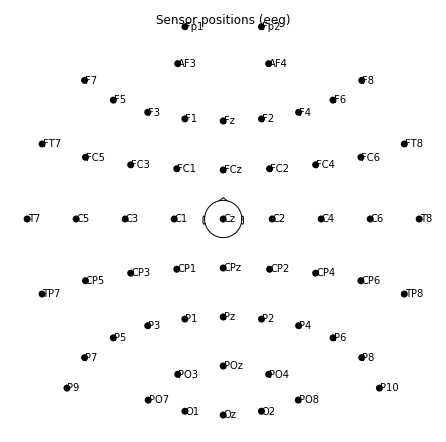

In [12]:
pos3d_eeg = pos3d_allChannels[channels_eeg,:]
dig_ch_pos = dict(zip(ch_names,pos3d_eeg))
montage = mne.channels.make_dig_montage(ch_pos=dig_ch_pos, nasion =[1,0,0])
montage.plot()
plt.close()

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


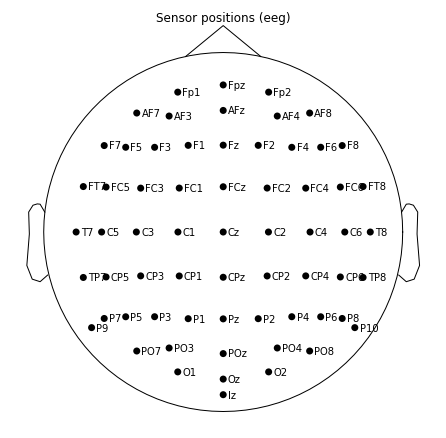

In [13]:
montage_std = make_standard_montage('biosemi64')
montage_std.plot()
plt.close()

In [14]:
raw.set_montage(montage_std)

<RawArray | 59 x 1619951 (8099.8 s), ~729.4 MB, data loaded>

## Plots

Effective window size : 10.240 (s)


<ipython-input-14-b0613066bbc9>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50,average = False, show =True) # ax=axes[0],


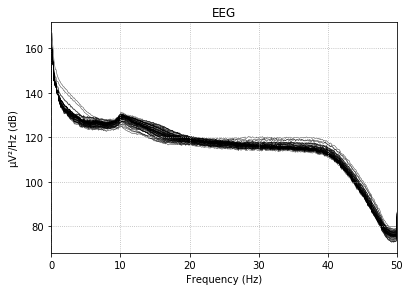

In [14]:
raw.plot_psd(fmax=50,average = False, show =True) # ax=axes[0],
plt.close()
#raw.plot_psd(fmax=50,average = True, ax=axes[1], show =True)

In [ ]:
# Do these same plots for event, no events, collison, no collison

## Add event information

In [15]:
events_brr = np.array(car_brake[car_brake>0]/5).astype(float)
events = np.empty([len(events_brr), 3],dtype=int)
events[:,0]=events_brr
events[:,1]=int(0)
events[:,2]=int(1)

In [16]:
events_brr # This is in ms 

array([  10554.,   18154.,   24151.,   30953.,   38152.,   46155.,
         51752.,   57952.,   66550.,   71951.,   80353.,   87750.,
         93950.,  100551.,  108349.,  115552.,  122553.,  128551.,
        134149.,  140549.,  147948.,  154149.,  162147.,  168548.,
        175749.,  183348.,  191547.,  197751.,  202547.,  208746.,
        217351.,  222150.,  230746.,  236945.,  242746.,  248745.,
        256945.,  263743.,  270946.,  278145.,  285145.,  292744.,
        299148.,  307544.,  314747.,  321743.,  328145.,  334143.,
        341142.,  348342.,  353141.,  360945.,  366741.,  371942.,
        383141.,  390739.,  397139.,  402738.,  409540.,  421141.,
        429541.,  435140.,  440339.,  445344.,  451137.,  459139.,
        466939.,  474740.,  482137.,  488336.,  496736.,  503936.,
        509136.,  514538.,  520337.,  527535.,  535536.,  550278.,
        557878.,  562876.,  569080.,  575275.,  582279.,  591075.,
        598282.,  605675.,  614275.,  619876.,  624677.,  6304

In [17]:
n_brakes = len(events) 
onset = events[:, 0]  
duration = np.repeat(0, n_brakes)  
description = ['car_brake'] * n_brakes 

### Create and add annotations containing event's information

In [18]:
annotations = mne.Annotations(onset, duration, description)  
raw.set_annotations(annotations)  

<ipython-input-18-696d516d9ce0>:2: RuntimeWarning: Omitted 230 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


<RawArray | 59 x 1619951 (8099.8 s), ~729.3 MB, data loaded>

Picks

In [19]:
# Picks corresponds to the channels if interest, to start all of them
picks = mne.pick_types (raw.info, meg=False, eeg=True, eog=False,
                            exclude='bads')

Epochs -  corresponds to segments of certain length around the events

In [45]:
epochs = mne.Epochs (raw, events, event_id=1, tmin=-0.3, tmax=1.2, proj=True,
                    picks=picks, baseline=(None, 0.1), preload=True,
                    reject=None)

Not setting metadata
Not setting metadata
230 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 230 events and 301 original time points ...
0 bad epochs dropped


In [20]:
epochs = mne.Epochs (raw, events, event_id=1, tmin=-4, tmax=4, proj=True,
                    picks=picks, baseline=(None, 0.1), preload=True,
                    reject=None)

Not setting metadata
Not setting metadata
230 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 230 events and 1601 original time points ...
1 bad epochs dropped


Evoked - corresponds to the average signales per electrode in the epochs

Computing rank from data with rank=None
    Using tolerance 0.00065 (2.2e-16 eps * 59 dim * 5e+10  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 183429
[done]


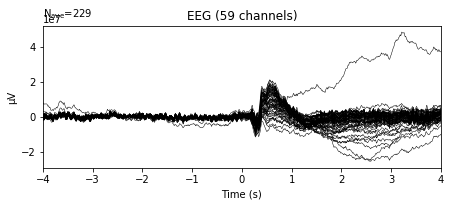

In [21]:
# compute evoked response and noise covariance,and plot evoked
evoked = epochs.average ()
cov = mne.compute_covariance (epochs, tmax=0)
evoked.plot()
plt.close()

In [47]:
X = epochs.get_data()  # EEG signals: n_epochs, n_eeg_channels, n_times
y = epochs.events[:, 2] 

### Collision Events 

In [48]:
# Find events with collision 
car_brake_y = car_brake[car_brake>0]
car_collision_y = car_collision[car_collision>0]
collison_label = []
for i in range(len(car_brake_y)):
    diff = car_collision_y - car_brake_y[i]
    if ( len(diff[diff>0])==0):
        collison_label.append(0)
    elif (min(diff[diff>0]) > 25000): # car_brake_y[i] is too far from any collision, so label = 0, 25000 is
        collison_label.append(0)
    else:
        collison_label.append(1)

In [49]:
events_brr = np.array(car_brake[car_brake>0]/5).astype(int) # should I use this, or as above? 
events_collison = np.empty([len(events_brr), 3],dtype=int)
events_collison[:,0]=events_brr
events_collison[:,1]=int(0)
events_collison[:,2]=collison_label

In [50]:
n_brakes = len(events_collison) 
onset = events_collison[:, 0]  
duration = np.repeat(0, n_brakes)  

In [51]:
description = np.array(['no_collison'] * n_brakes)
description[np.where(np.array(collison_label)==1)]='collison'

In [52]:
annotations = mne.Annotations(onset, duration, description)  
raw.set_annotations(annotations) 

<ipython-input-52-a9c262bf5906>:2: RuntimeWarning: Omitted 230 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


<RawArray | 59 x 1619951 (8099.8 s), ~729.4 MB, data loaded>

In [53]:
epochs_collison = mne.Epochs (raw, events_collison, event_id=1, tmin=-0.3, tmax=0.6, proj=True,
                    picks=picks, baseline=(None, 0), preload=True,
                    reject=None)
epochs_noncollison = mne.Epochs (raw, events_collison, event_id=0, tmin=-0.3, tmax=0.6, proj=True,
                    picks=picks, baseline=(None, 0), preload=True,
                    reject=None)

Not setting metadata
Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 36 events and 181 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
194 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 194 events and 181 original time points ...
0 bad epochs dropped


In [54]:
# compute evoked response and noise covariance,and plot evoked
evoked_collison = epochs_collison.average ()
cov = mne.compute_covariance (epochs_collison, tmax=0)

evoked_noncollison = epochs_noncollison.average ()
cov = mne.compute_covariance (epochs_noncollison, tmax=0)

Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 59 dim * 2.8e+09  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 2196
[done]
Computing rank from data with rank=None
    Using tolerance 9.2e-05 (2.2e-16 eps * 59 dim * 7e+09  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 11834
[done]


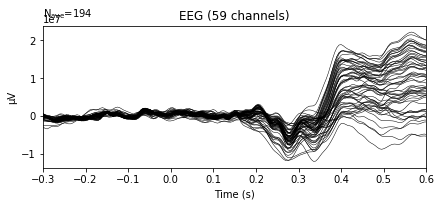

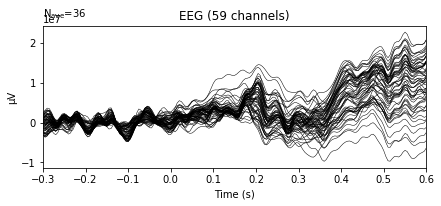

In [55]:
evoked_noncollison.plot()
evoked_collison.plot()
plt.close()

Verify with randomly assaigned labels

In [31]:
random_label = np.random.randint(2, size=230)
events_brr = np.array(car_brake[car_brake>0]/5).astype(int) # should I use this, or as above? 
events_collison = np.empty([len(events_brr), 3],dtype=int)
events_collison[:,0]=events_brr
events_collison[:,1]=int(0)
events_collison[:,2]=random_label

n_brakes = len(events_collison) 
onset = events_collison[:, 0]  
duration = np.repeat(0.1, n_brakes)  

description = np.array(['no_collison'] * n_brakes)
description[np.where(np.array(random_label)==1)]='collison'

annotations = mne.Annotations(onset, duration, description)  
raw.set_annotations(annotations) 

<ipython-input-31-fe48cadaa394>:16: RuntimeWarning: Omitted 230 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


<RawArray | 59 x 1619951 (8099.8 s), ~729.4 MB, data loaded>

In [32]:
epochs_collison = mne.Epochs (raw, events_collison, event_id=1, tmin=-0.3, tmax=1.2, proj=True,
                    picks=picks, baseline=(None, 0), preload=True,
                    reject=None)
epochs_noncollison = mne.Epochs (raw, events_collison, event_id=0, tmin=-0.3, tmax=1.2, proj=True,
                    picks=picks, baseline=(None, 0), preload=True,
                    reject=None)

Not setting metadata
Not setting metadata
118 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 118 events and 301 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
112 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 112 events and 301 original time points ...
0 bad epochs dropped


In [33]:
# compute evoked response and noise covariance,and plot evoked
evoked_collison = epochs_collison.average ()
cov = mne.compute_covariance (epochs_collison, tmax=0)

evoked_noncollison = epochs_noncollison.average ()
cov = mne.compute_covariance (epochs_noncollison, tmax=0)

Computing rank from data with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 59 dim * 5.3e+09  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 7198
[done]
Computing rank from data with rank=None
    Using tolerance 7e-05 (2.2e-16 eps * 59 dim * 5.4e+09  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 6832
[done]


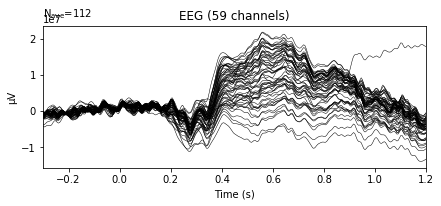

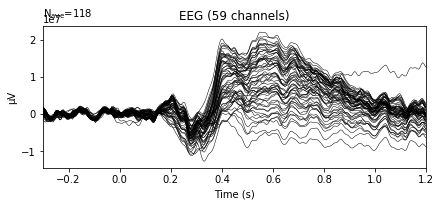

In [34]:
evoked_noncollison.plot()
evoked_collison.plot()
plt.close()

## Decoding (MVPA)

In [38]:
event_id = {'no_collison': 0, 'collison': 1}  # just use two

In [39]:
n_brakes = len(events) 
onset = events[:, 0]  
duration = np.repeat(0, n_brakes)
description = ['car_brake'] * n_brakes 
annotations = mne.Annotations(onset, duration, description)  
raw.set_annotations(annotations)  

<ipython-input-39-0432cb63234e>:6: RuntimeWarning: Omitted 230 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


<RawArray | 59 x 1619951 (8099.8 s), ~729.4 MB, data loaded>

In [40]:
#raw.filter(2, 45) # Data seems to be already down sample (https://lampx.tugraz.at/~bci/database/002-2016/description.txt)

In [41]:
# Read epochs
epochs = mne.Epochs(raw, events_collison, event_id, tmin=-0.3, tmax=1.2, proj=True,
                    picks=picks, baseline=(None, 0.1), preload=True,
                    reject=None)

Not setting metadata
Not setting metadata
230 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 230 events and 301 original time points ...
0 bad epochs dropped


In [43]:
epochs.pick_types(eeg=True, exclude='bads')

<Epochs |  230 events (all good), -0.3 - 1.2 sec, baseline [None, 0.1], ~31.3 MB, data loaded,
 'collison': 36
 'no_collison': 194>

In [44]:
# compute evoked response and noise covariance,and plot evoked
evoked = epochs.average ()
cov = mne.compute_covariance (epochs, tmax=0)

Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 59 dim * 7.8e+09  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 14030
[done]


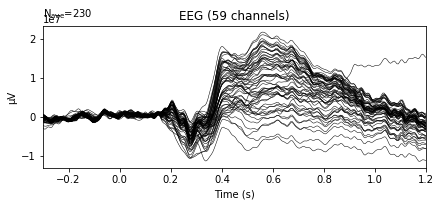

In [45]:
evoked.plot()
plt.close()

In [79]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

In [47]:
X = epochs.get_data()  # EEG signals: n_epochs, n_eeg_channels, n_times
y = epochs.events[:, 2]  # target: Collision Yes or No

In [70]:
epochs_train = epochs.copy().crop(tmin=-0.6, tmax=1.2)

<ipython-input-70-311c26e7ab06>:1: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  epochs_train = epochs.copy().crop(tmin=-0.6, tmax=1.2)


In [71]:
epochs_train

<Epochs |  230 events (all good), -0.3 - 1.2 sec, baseline [None, 0.1], ~31.3 MB, data loaded,
 'collison': 36
 'no_collison': 194>

In [72]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


In [73]:
labels = epochs.events[:, -1] 

In [74]:
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e+02 (2.2e-16 eps * 59 dim * 1.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+02 (2.2e-16 eps * 59 dim * 1.6e+16  max singular value)


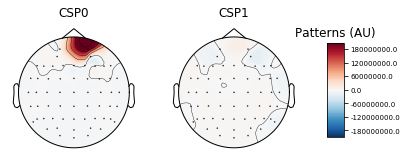

In [86]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.close()

Computing rank from data with rank=None
    Using tolerance 3.4e+02 (2.2e-16 eps * 59 dim * 2.6e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e+02 (2.2e-16 eps * 59 dim * 1.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e+02 (2.2e-16 eps * 59 dim * 2.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+02 (2.2e-16 eps * 59 dim * 1.6e+16  max singular value)


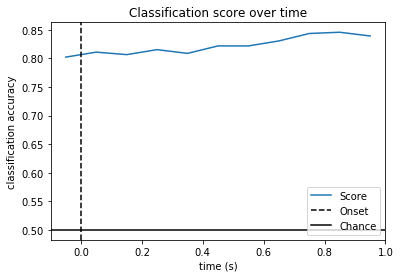

In [87]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

### Vectorizer

In [88]:
# Uses all MEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LogisticRegression(solver='lbfgs'))

scores = cross_val_multiscore(clf, X, y, cv=15, n_jobs=1)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))

Spatio-temporal: 77.9%


In [89]:
csp = CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(csp, LinearModel(LogisticRegression(solver='lbfgs')))
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=1)
print('CSP: %0.1f%%' % (100 * scores.mean(),))

Computing rank from data with rank=None
    Using tolerance 3.6e+02 (2.2e-16 eps * 59 dim * 2.7e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.9e+02 (2.2e-16 eps * 59 dim * 2.2e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e+02 (2.2e-16 eps * 59 dim * 2.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+02 (2.2e-16 eps * 59 dim * 1.7e+16  max singular value)


Computing rank from data with rank=None
    Using tolerance 3.9e+02 (2.2e-16 eps * 59 dim * 3e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.9e+02 (2.2e-16 eps * 59 dim * 2.2e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


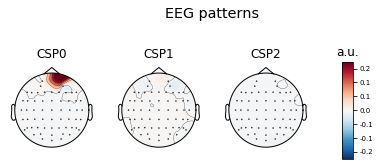

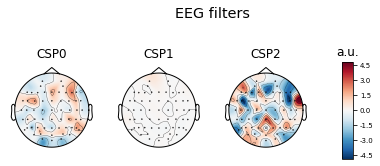

In [102]:
# Fit CSP on full data and plot
csp.fit(X, y)
csp.plot_patterns(epochs.info, scalings=1e-3, title= 'EEG patterns')
csp.plot_filters(epochs.info, scalings=1e2, title= 'EEG filters')
plt.close()

### Temporal decoding

Text(0.5, 1.0, 'Sensor space decoding')

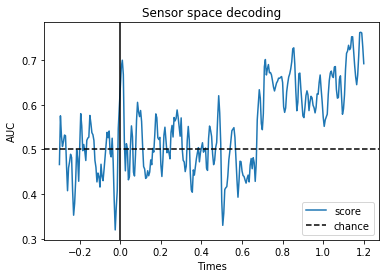

In [103]:
# We will train the classifier on all left visual vs auditory trials on MEG

clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

In [105]:
len(scores)

301


No projector specified for this dataset. Please consider the method self.add_proj.


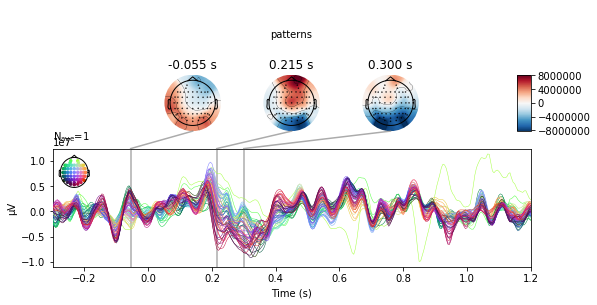

In [190]:
clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs')))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times="peaks", title='patterns',
                           **joint_kwargs)
plt.close()


No projector specified for this dataset. Please consider the method self.add_proj.


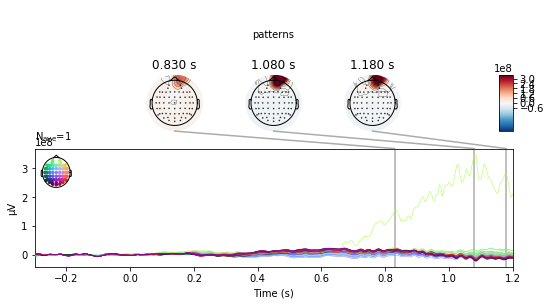

In [106]:
clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs')))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times="peaks", title='patterns',
                           **joint_kwargs)
plt.close()


No projector specified for this dataset. Please consider the method self.add_proj.


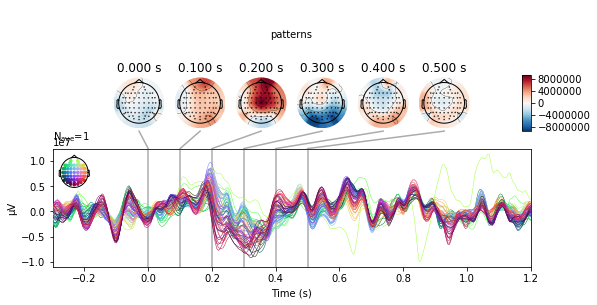

In [193]:
clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs')))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.arange(0., .600, .100), title='patterns',
                           **joint_kwargs)
plt.close()


No projector specified for this dataset. Please consider the method self.add_proj.


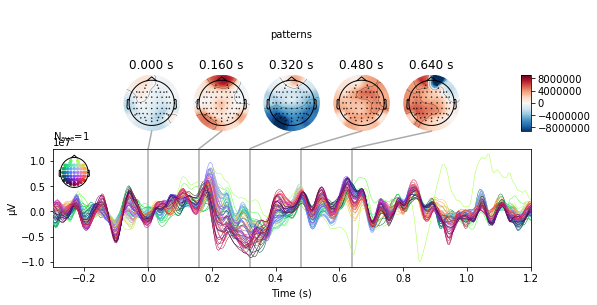

In [199]:
clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs')))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.array([0., .160, .320, .480, .640]), title='patterns',
                           **joint_kwargs)
plt.close()

array([1, 2, 3])

In [189]:
evoked_time_gen

<Evoked | '' (average, N=1), [-0.3, 1.2] sec, 59 ch, ~304 kB>

# Miscellaneous 

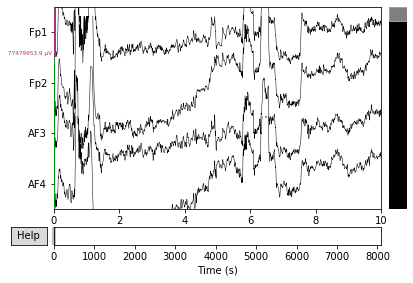

In [120]:
# It is also possible to auto-compute scalings
scalings = 'auto'  # Could also pass a dictionary with some value == 'auto'
raw.plot(n_channels=4, scalings=scalings, title='Auto-scaled Data from arrays',
         show=True, block=True)
plt.close()

### Example of how to use CSD

Fitted sphere radius:         95.0 mm
Origin head coordinates:      -0.0 -0.0 40.1 mm
Origin device coordinates:    -0.0 -0.0 40.1 mm
No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


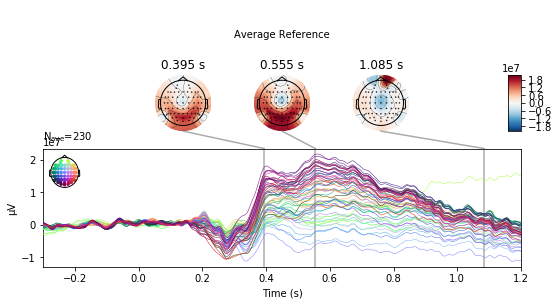

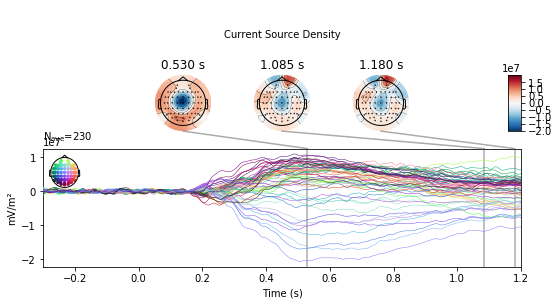

In [195]:
# CSD takes the spatial Laplacian of the sensor signal (derivative in both x and y). 
# It does what a planar gradiometer does in MEG. Computing these spatial derivatives reduces point spread. 
# CSD transformed data have a sharper or more distinct topography, reducing the negative impact of volume conduction.
times = np.array([-0.1, 0., 0.05, 0.1, 0.15])
evoked_csd = mne.preprocessing.compute_current_source_density(evoked)
evoked.plot_joint(title='Average Reference', show=False)
evoked_csd.plot_joint(title='Current Source Density')
plt.close()

### set up and fit the ICA

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 20 components
Fitting ICA took 35.4s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
4049 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
4049 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


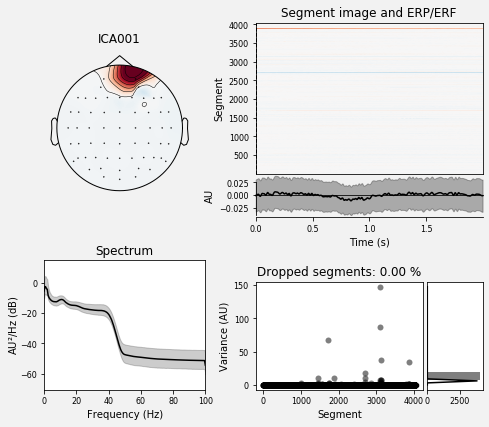

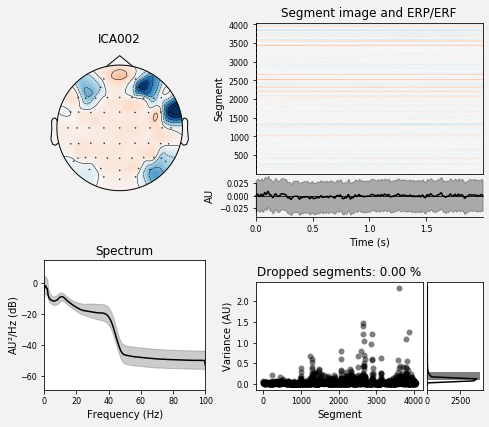

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [196]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

### Display all events events for subject 

Experiments consisted of three blocks (45 min each, marked with grey vertical dash) of driving with rest periods of 10–15 min in between.
During these blocks, 225 ± 17 critical (emergency braking) situations were artificially induced

Text(0.5, 1.0, 'Events subject VPja.mat')

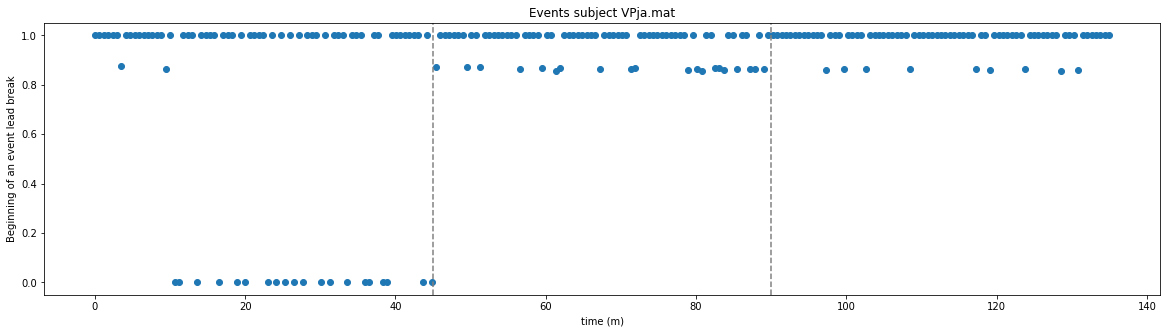

In [8]:
lead_brake_index = 63 # Index for channel 'lead_brake'
m = 100
events = np.array(car_brake[car_brake>0]/5).astype(int)
plt.figure(figsize=(20,5))
plt.plot(np.linspace(start = 0, stop = x.shape[1], num =len(x[lead_brake_index,events]))/200/60, x[lead_brake_index,events], linestyle=' ', marker="o")
plt.axvline(x=45, color='gray', linestyle='--')
plt.axvline(x=90, color='gray', linestyle='--')
plt.xlabel("time (m)")
plt.ylabel("Beginning of an event lead break")
plt.title('Events subject ' + file_name)

### Display distance to lead vehicle

Text(0.5, 1.0, 'Distance to lead vehicle, subject VPja.mat')

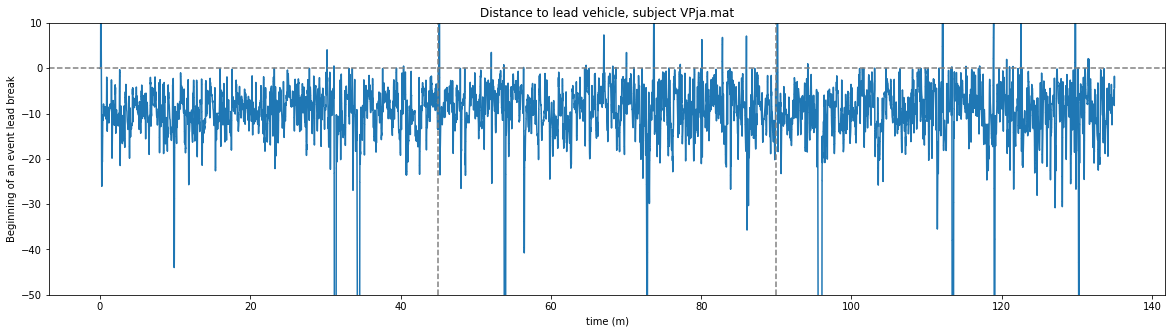

In [9]:
lead_brake_index = 63 # Index for channel 'lead_brake'
m = 100
events = np.array(car_brake[car_brake>0]/5).astype(int) # In time ms
plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,len(x[64,:]),len(x[64,:]))/200/60, x[64,:], label="dist_to_lead")
plt.axvline(x=45, color='gray', linestyle='--')
plt.axvline(x=90, color='gray', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("time (m)")
plt.ylim(-50,10)
plt.ylabel("Beginning of an event lead break")
plt.title('Distance to lead vehicle, subject ' + file_name)

### Display a typical event

In [10]:
# Event index
event_index = 26 #144 #37, 144 #  Index of an event

# Target segment interval intial point, time step corresponds to 5ms
ts_i = 60

# Target segment interval intial point
ts_f = 260 

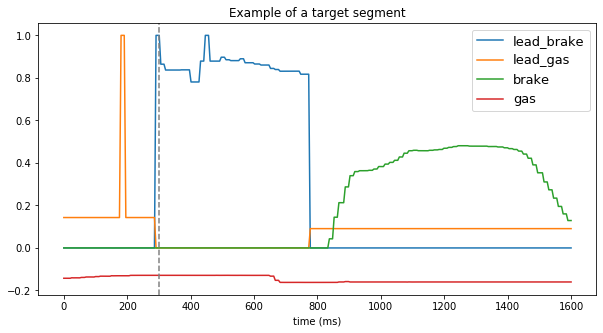

In [11]:
event_tiem = events[event_index]
plt.figure(figsize=(10,5))
x1 = np.linspace(start = 0, stop =(ts_i+ts_f)*5, num =(ts_i+ts_f))
plt.plot(x1,x[lead_brake_index,event_tiem-ts_i:event_tiem+ts_f], label="lead_brake")
plt.plot(x1,x[62,event_tiem-ts_i:event_tiem+ts_f], label="lead_gas")
plt.plot(x1,x[68,event_tiem-ts_i:event_tiem+ts_f], label = "brake")
plt.plot(x1,x[67,event_tiem-ts_i:event_tiem+ts_f], label = "gas")
#plt.plot(x1,x[61,event_tiem-ts_i:event_tiem+ts_f]/350, label = "EMGf")
#plt.plot(x1,x[64,event_tiem-ts_i:event_tiem+ts_f], label = "dist_to_lead")
plt.axvline(x=ts_i*5, color='gray', linestyle='--')
plt.xlabel("time (ms)")
plt.legend(fontsize=13)
plt.title("Example of a target segment") 
plt.savefig("Plots/typicalEvent.png")

<br>
<hr>

## Event-related potentials (ERP)


Construct matrix with all target segments for channel chn_name

In [12]:
# Target segment interval intial point -> corresponds to 300ms
ts_i = 60 

# Target segment interval intial point -> corresponds to 1200ms
ts_f = 240 

# chn_name
chn_name = "P9"

In [13]:
A = np.zeros((len(events), ts_f+ts_i))
for event_index in range(len(events)-1):
    event_tiem = events[event_index]
    A[event_index,:] = x[np.where(np.asarray(name_elec) == chn_name)[0],event_tiem-ts_i:event_tiem+ts_f]
print(A.shape)   

(230, 300)


### Display chn_name ERP

Text(0.5, 1.0, 'Channel P9')

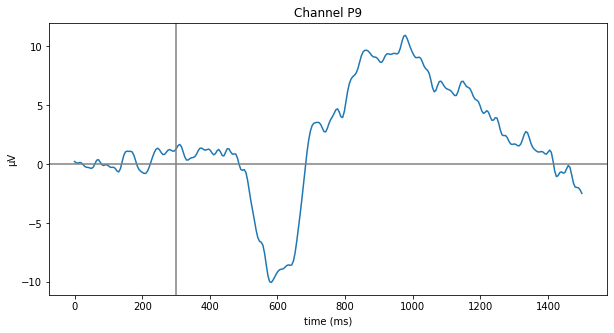

In [14]:
plt.figure(figsize=(10,5))
A_norm = np.subtract(A,np.array(A[:,:20].mean(1)).reshape(A.shape[0],1))
plt.plot(np.linspace(start = 0, stop = A_norm.shape[1]*5, num =A_norm.shape[1]), A_norm.mean(0))
plt.axvline(x=ts_i*5, color='gray', linestyle='-')
plt.axhline(y=0, color='gray', linestyle='-')
plt.xlabel("time (ms)")
plt.ylabel(u"\u03bcV")
plt.title('Channel ' + chn_name)

Costruct matrix with non target segments 

In [15]:
# Intervals of segments without an event
noevents_int = np.append(np.append(0, events), x.shape[1])

# Length of intervals
noevents_len = np.diff(noevents_int)

# Index of EEG electrodes
channels_eeg = np.delete(np.arange(61), [0, 5])

In [16]:
gap_sml = 600 # corresponds to 3000 ms apart from any stimulus
nts_offset = 100 # 500 ms
A_noEvent = []
for event_index in range(len(noevents_len)):
    noevents_seg = int((noevents_len[event_index] - gap_sml*2 - ts_i + ts_f) / nts_offset)
    if(noevents_seg>0):
        for noevent_ix in range(noevents_seg):
            ip = noevents_int[event_index] + gap_sml + nts_offset*noevent_ix
            fp = ip + ts_i + ts_f
            A_noEvent.append(x[channels_eeg, ip:fp]) 

### Display normal activity 

Text(0.5, 1.0, 'Normal brain activity')

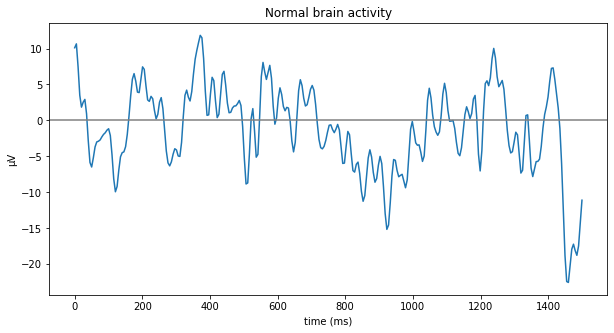

In [17]:
non_target_index = rnd.randint(0, len(A_noEvent))
plt.figure(figsize=(10,5))
A_norm = np.subtract(A_noEvent[non_target_index],np.array(A_noEvent[non_target_index][:,:20].mean(1)).reshape(A_noEvent[non_target_index].shape[0],1))
plt.plot(np.linspace(start = 0, stop = A_norm.shape[1]*5, num =A_norm.shape[1]), A_norm.mean(0))
plt.axhline(y=0, color='gray', linestyle='-')
plt.xlabel("time (ms)")
plt.ylabel(u"\u03bcV")
plt.title('Normal brain activity')


### Display activity maps

In [18]:
# Load target segment
mat_pp_event = np.load(path_postprocess_mat + 'AllSubjects_events/VPja.mat_segment_3_event.npy')

# Load non-target segme,t
mat_pp_noevent = np.load(path_postprocess_mat + 'VPja_all/VPja.mat_segment_150_noevent.npy')

vmin = min(np.min(mat_pp_event),np.min(mat_pp_noevent))
vmax = min(np.max(mat_pp_event),np.max(mat_pp_noevent))

Text(0.5, 1.0, 'EEG for an event segment')

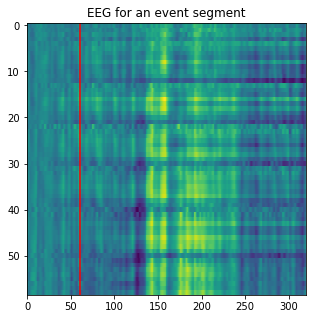

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(mat_pp_event, vmin=vmin, vmax=vmax, aspect='auto')
plt.axvline(x=60, color='red', linestyle='-')
plt.title('EEG for an event segment')

Text(0.5, 1.0, 'EEG for an normal segment')

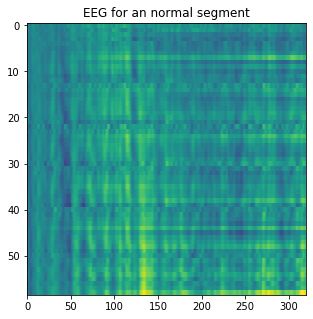

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(mat_pp_noevent, vmin=vmin, vmax=vmax, aspect='auto')
plt.title('EEG for an normal segment')

<br>
<hr>

## Performance measures


Define and compute relevant performence measures of the drivers actions

### Collision

Label event segments either as collision events or no collision evenet

In [21]:
# Find events with collision 
car_brake_y = car_brake[car_brake>0]
car_collision_y = car_collision[car_collision>0]
collison_label = []
for i in range(len(car_brake_y)):
    diff = car_collision_y - car_brake_y[i]
    if ( len(diff[diff>0])==0):
        collison_label.append(0)
    elif (min(diff[diff>0]) > 25000): # car_brake_y[i] is too far from any collision, so label = 0, 25000 is
        collison_label.append(0)
    else:
        collison_label.append(1)
events_collisions = np.where(np.asarray(collison_label)==1)[0]

Display a collision event

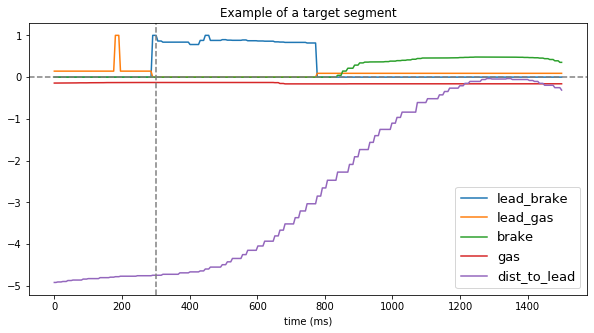

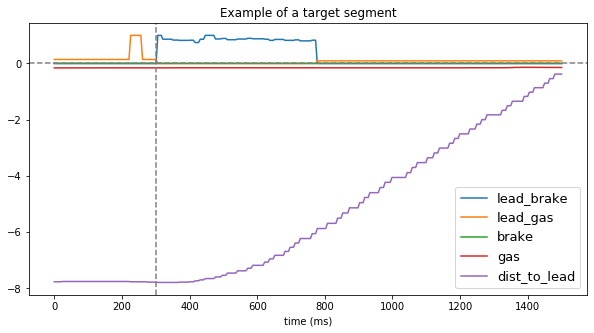

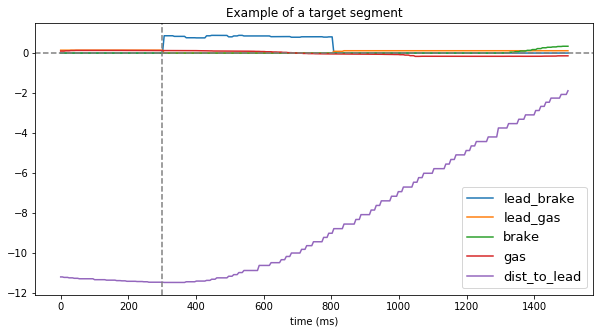

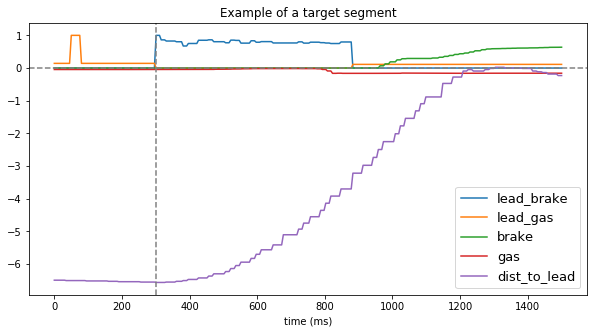

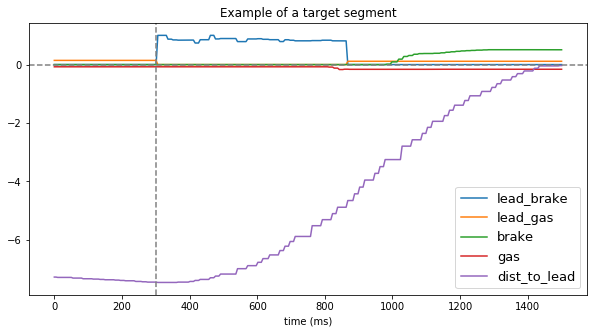

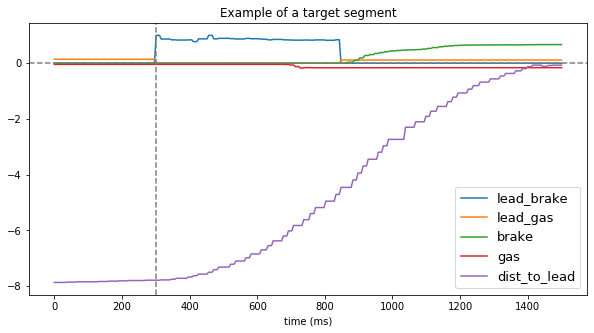

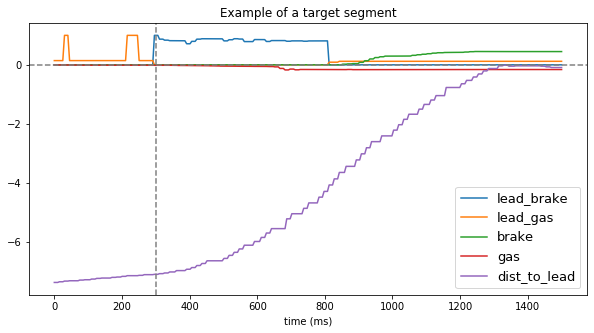

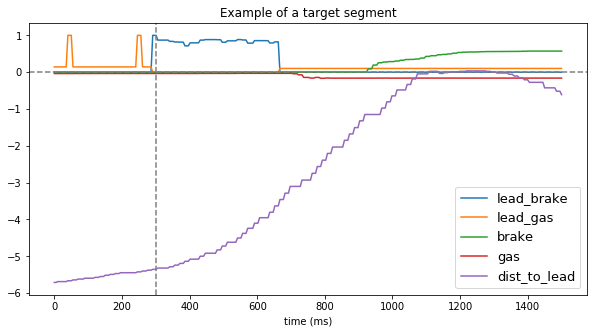

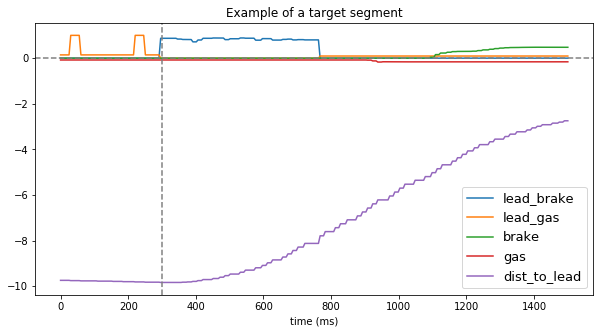

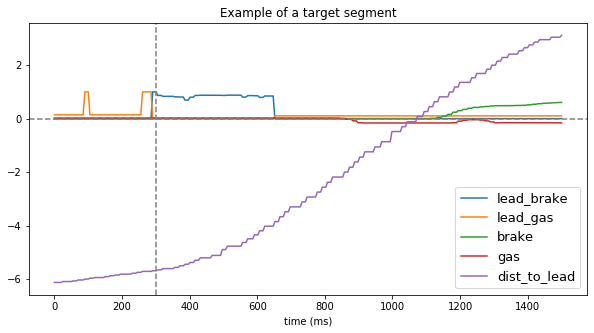

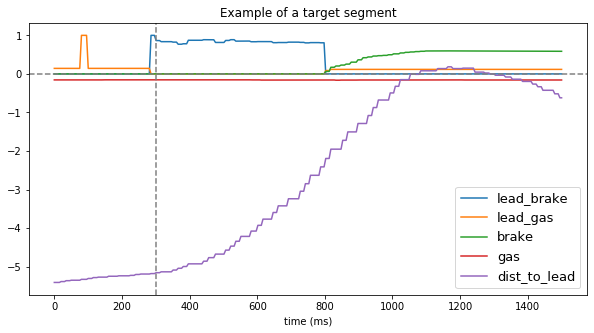

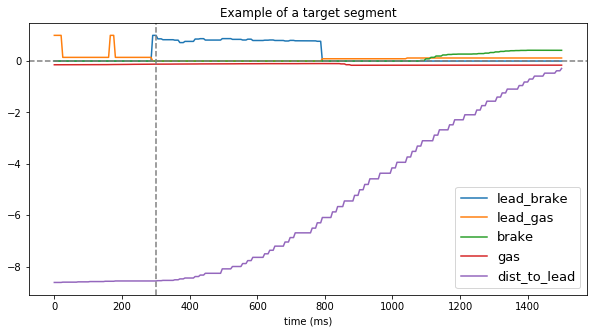

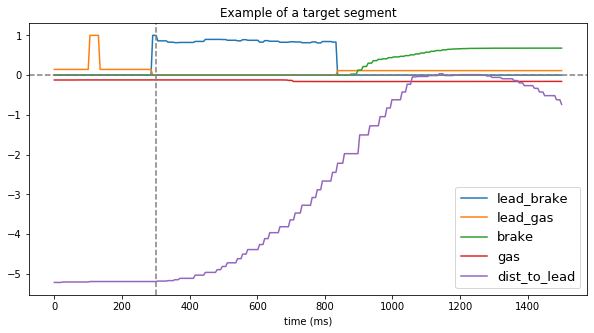

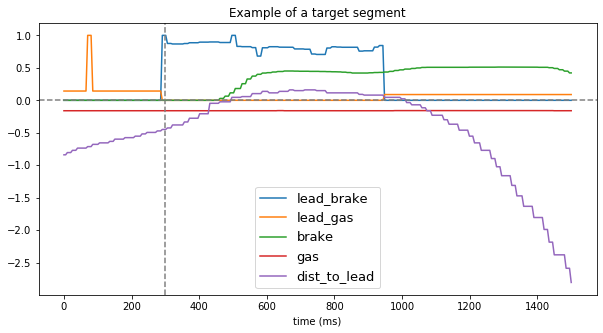

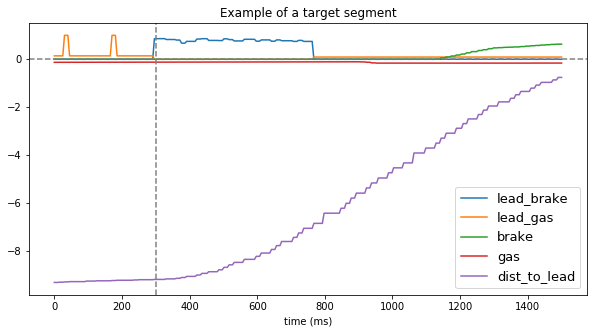

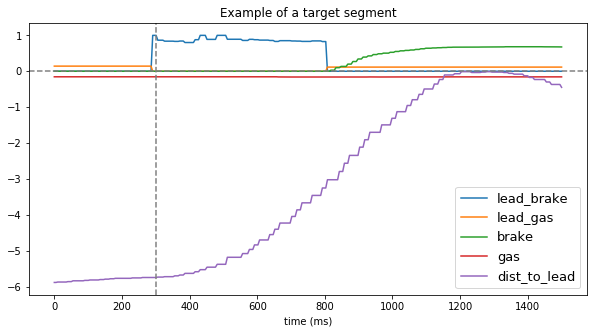

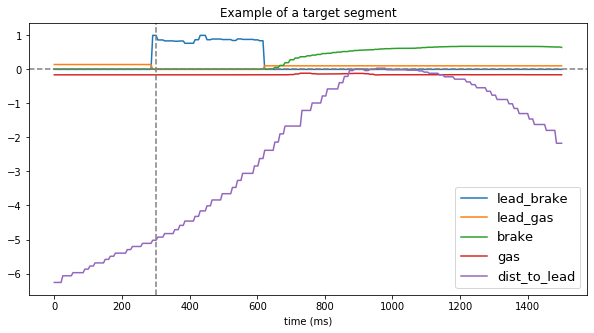

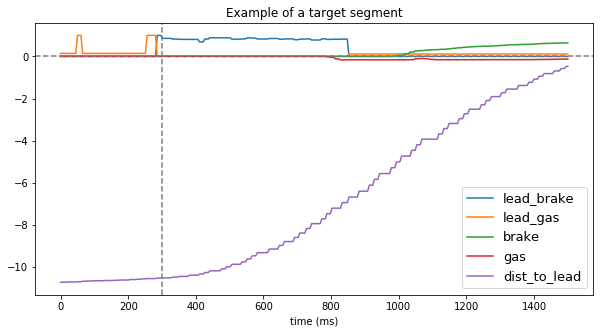

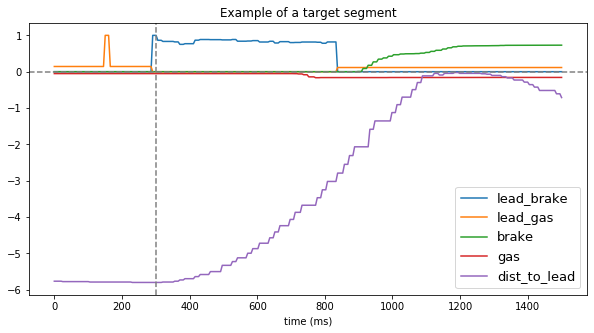

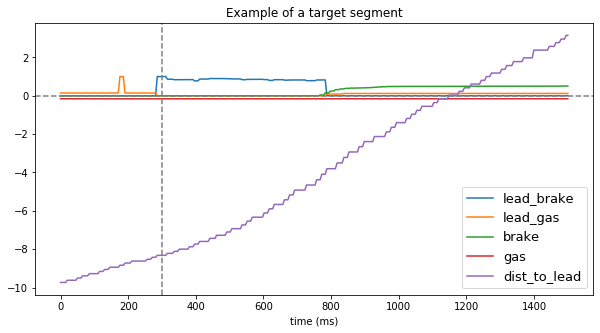

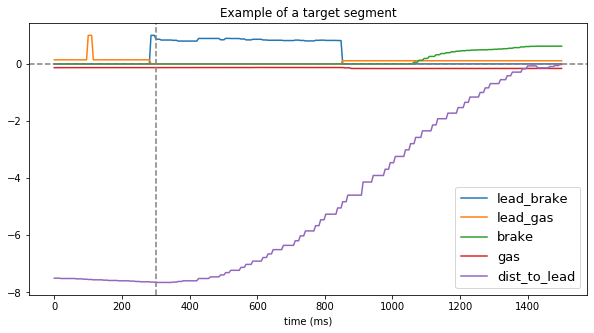

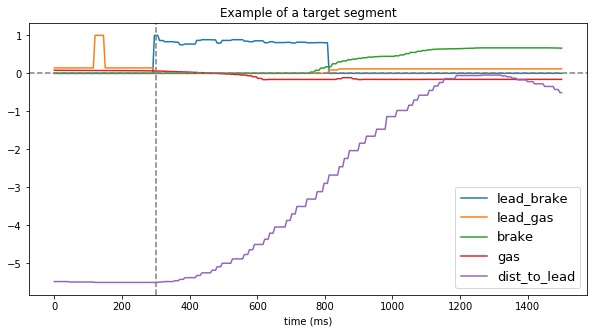

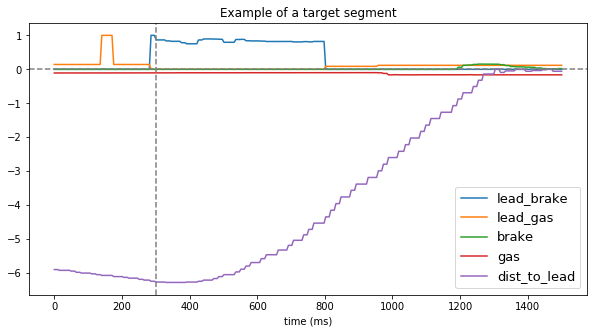

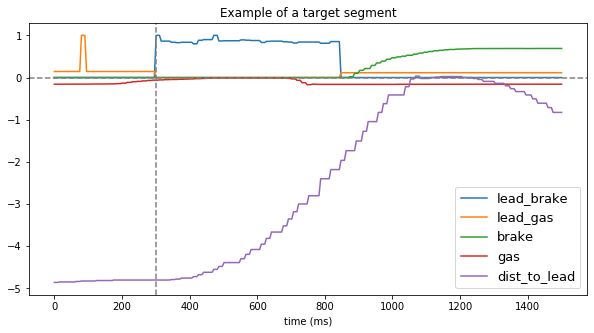

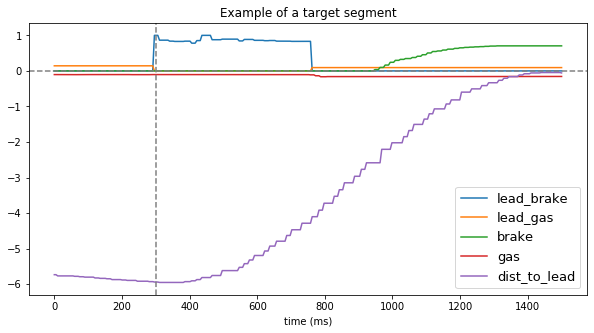

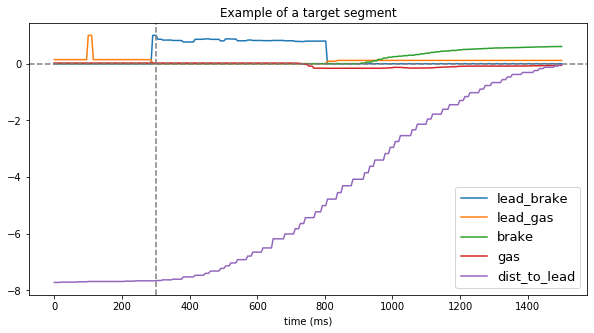

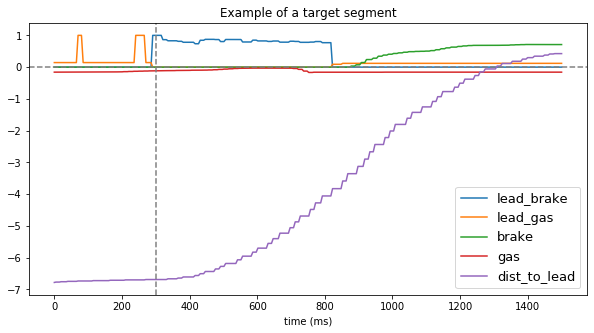

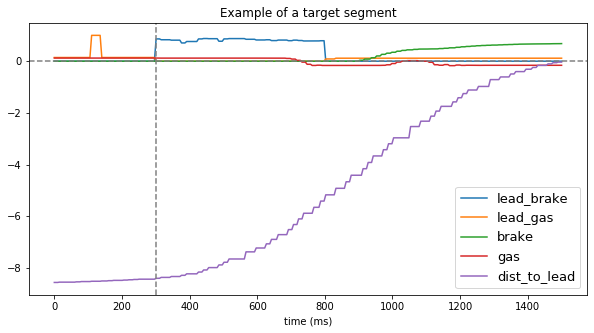

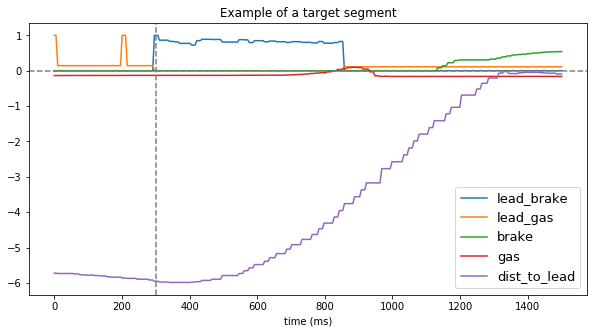

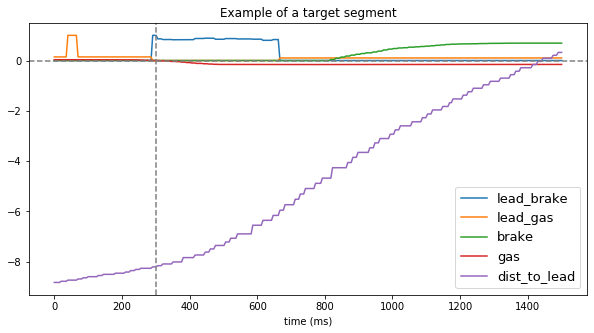

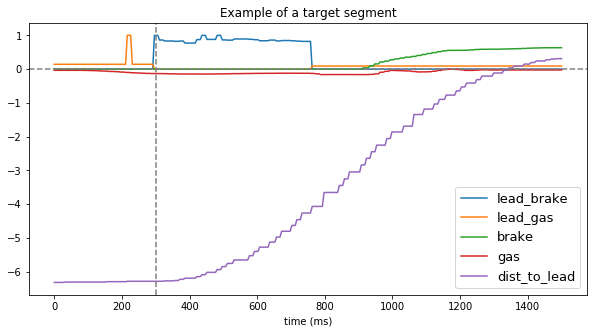

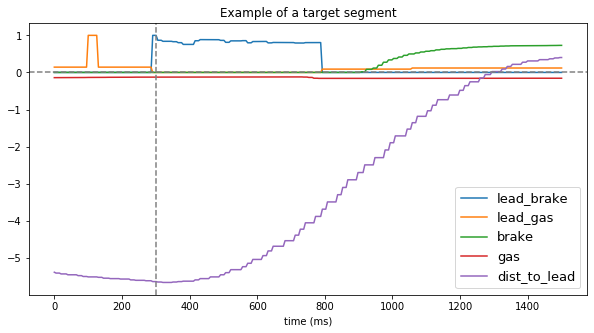

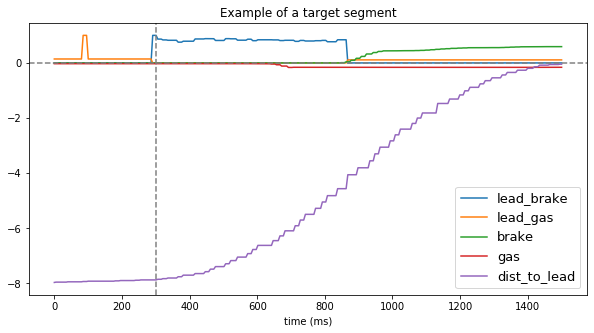

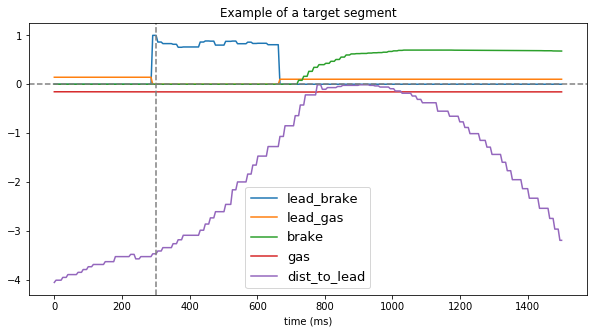

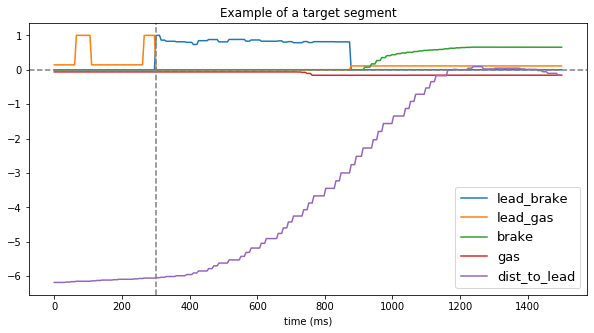

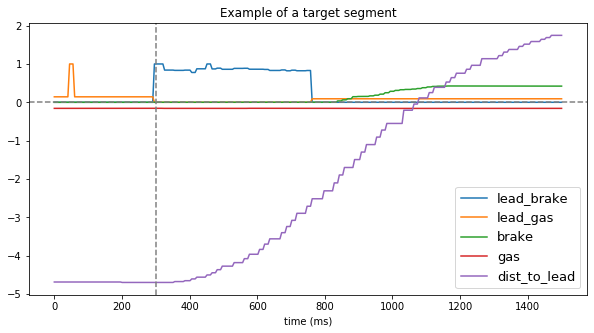

In [22]:
#plt.rcParams.update({'figure.max_open_warning': 1})
for event_collision in range(len(events_collisions)):
    event_tiem = events[events_collisions[event_collision]]
    plt.figure(figsize=(10,5))
    x1 = np.linspace(start = 0, stop =(ts_i+ts_f)*5, num =(ts_i+ts_f))
    plt.plot(x1,x[lead_brake_index,event_tiem-ts_i:event_tiem+ts_f], label="lead_brake")
    plt.plot(x1,x[62,event_tiem-ts_i:event_tiem+ts_f], label="lead_gas")
    plt.plot(x1,x[68,event_tiem-ts_i:event_tiem+ts_f], label = "brake")
    plt.plot(x1,x[67,event_tiem-ts_i:event_tiem+ts_f], label = "gas")
    #plt.plot(x1,x[61,event_tiem-ts_i:event_tiem+ts_f]/350, label = "EMGf")
    plt.plot(x1,x[64,event_tiem-ts_i:event_tiem+ts_f], label = "dist_to_lead")
    plt.axvline(x=ts_i*5, color='gray', linestyle='--')
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.xlabel("time (ms)")
    plt.legend(fontsize=13)
    plt.title("Example of a target segment") 
    plt.savefig("Plots/collision_" + file_name[:4] +"/typicalEvent_" + str(event_collision) + ".png")
    plt.show()


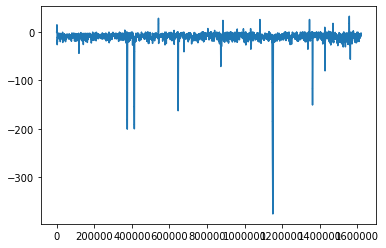

In [23]:
 plt.plot(x[64,:], label = "dist_to_lead")

Undersample no events

In [52]:
from sklearn.utils import resample

In [173]:
event_collison = np.where(np.asarray(collison_label)==1)[0]

In [174]:
event_not_collison = np.where(np.asarray(collison_label)==0)[0]

In [156]:
# downsample majority
event_not_collison_downsampled = resample(event_not_collison,
                                replace = False,                 # sample without replacement
                                n_samples = len(event_collison), # match minority n
                                random_state = 27)               # reproducible results

### Reaction time

Retain only events when the subject reacted, i.e. react_emg > 0

In [24]:
car_brake_y = car_brake[car_brake>0]
react_emg_y = react_emg[react_emg>0] # react_emg
react_time = []
event_noreact = []
for i in range(len(car_brake_y)): #
    diff = react_emg_y - car_brake_y[i]
    if ( len(diff[diff>0])==0):
        event_noreact.append(i)
    elif (min(diff[diff>0]) > 10000):
        event_noreact.append(i)
    else:
        react_time.append(min(diff[diff>0]))

No handles with labels found to put in legend.


431.1725663716814
16016.65606155533
126.55692814522376
226


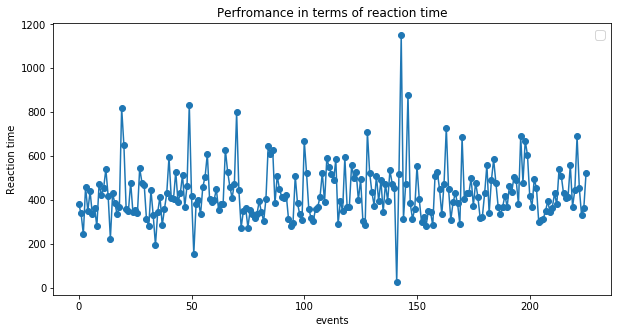

In [25]:
plt.figure(figsize=(10,5))
events_react_y = np.delete(events,event_noreact)
plt.plot(react_time,marker='o' ) # t/dist_to_lead
#temp = np.array(react_time)/400
#plt.plot(temp,marker='o' ) # t/dist_to_lead
plt.xlabel("events")
plt.ylabel("Reaction time")
plt.legend(fontsize=13)
plt.title("Perfromance in terms of reaction time")
react_time_mean = np.asarray(react_time).mean()
react_time_std = np.asarray(react_time).std()
print(np.asarray(react_time).mean())
print(np.asarray(react_time).var())
print(np.asarray(react_time).std())
print(len(react_time))

Compare to the experimental recording of reaction time

Text(0.5, 1.0, 'Perfromance in terms of reaction time')

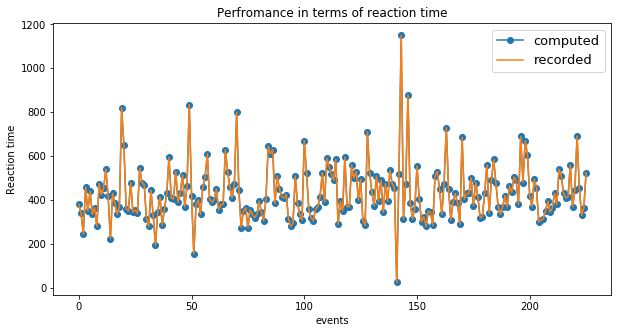

In [26]:
react_time_recorded = react[0][np.isfinite(react[0])]
plt.figure(figsize=(10,5))
events_react_y = np.delete(events,event_noreact)
plt.plot(react_time,marker='o', label="computed" ) # t/dist_to_lead
plt.plot(react_time_recorded, label="recorded")
#temp = np.array(react_time)/400
#plt.plot(temp,marker='o' ) # t/dist_to_lead
plt.xlabel("events")
plt.ylabel("Reaction time")
plt.legend(fontsize=13)
plt.title("Perfromance in terms of reaction time")

#react_time_exp = react[0][np.isfinite(react[0])]
#plt.plot(react_time_exp)
#print(len(react_time_exp))

Find the distribution of reaction time. It is used to compare the results of the NN when it is fitted over random values, following this distribution

In [27]:
from scipy.stats import norm
dist = norm(react_time_mean, react_time_std)
values = [value for value in range(100, 800)]
probabilities = [dist.pdf(value) for value in values]
s = np.random.normal(react_time_mean, react_time_std, 1)

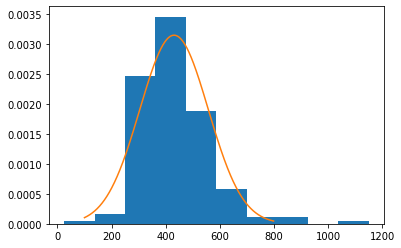

In [28]:
plt.hist(react_time, bins=10, density=True)
plt.plot(values, probabilities)
#plt.plot(s)

### Performance in terms of (t,d)

Compute perfomance dfined as $\frac{t}{d^2}$, where $t$ is the reaction time and $d$ the distance to lead, at the moment of break

No handles with labels found to put in legend.


18.87932332963154
4.34503433008665


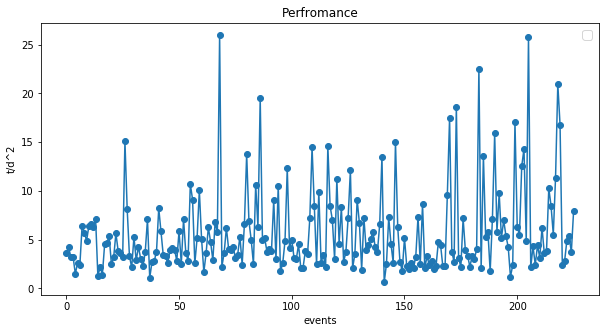

In [29]:
plt.figure(figsize=(10,5))
events_react_y = np.delete(events,event_noreact)
perf = react_time /np.power(x[64,events_react_y],2)
#plt.plot(perf/5,marker='o' ) # t/dist_to_lead
plt.plot(perf,marker='o' )
#temp = np.array(react_time)/400
#plt.plot(temp,marker='o' ) # t/dist_to_lead
plt.xlabel("events")
plt.ylabel("t/d^2")
plt.legend(fontsize=13)
plt.title("Perfromance")
print(np.asarray(perf).var())
print(np.asarray(perf).std())

Correlation between performance $\frac{t}{d^2}$ and the reaction time to breaking event

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Correlation between measures of perf')

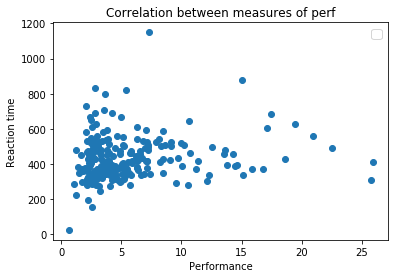

In [30]:
plt.plot(perf,react_time_recorded,marker='o',linestyle=" " )
plt.xlabel("Performance")
plt.ylabel("Reaction time")
plt.legend(fontsize=13)
plt.title("Correlation between measures of perf")

TypeError: only size-1 arrays can be converted to Python scalars